# Deel 2: Missing Values/Proximity Matrix
Wat zijn de grote krachten van een randomforest? Dat het relatief minder uitmaakt als bij andere algoritmes dat de data schoon is. Hieronder gaan we een paar oefeningen doen om deze missende data zo goed mogelijk te interpreteren.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import clear_output
import random
random.seed(430)

from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter('ignore')

We laden hier de heart-disease dataset in, maar we verwijderen allerlei random waarden in de test dataset.
Wij gaan proberen om die waarden zo goed mogelijk in te vullen en een zo hoog mogelijke score te krijgen

In [2]:
df = pd.read_csv("dataset/heart.csv")
print(df.columns)
df.head(5)

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
df = df[['sex','age','chol','trestbps','exang', 'target']]
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['target']), df['target'], test_size=80, random_state=99)

In [4]:
for index, row in X_test.iterrows():
    for x in range(1):
        col_to_clear = random.choice((X_test).columns)
        X_test[col_to_clear][index] = np.nan

In [5]:
print("Train dataset size:",X_train.shape[0])
print("Test dataset size", X_test.shape[0])

Train dataset size: 223
Test dataset size 80


Met deze functie kun je de accuracy van je invulling van missende waarden

In [6]:
clf = RandomForestClassifier(random_state=95, min_samples_split=10)
clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=95, verbose=0,
                       warm_start=False)

In [7]:
def test_model(clf, X_train, X_test, y_train, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return accuracy_score(y_pred, y_test)

Hieronder zie je de testdata. Hierin mist in elke row een colom met data. Het algemene idee is dat we eerst een (waarschijnlijk) slechte schatting gaan maken, en deze dan gedurende wijs te verbeteren.

In [8]:
X_test.head(10)

,sex,age,chol,trestbps,exang
137,1.0,62.0,NaN,128.0,0.0
262,1.0,NaN,282.0,123.0,1.0
43,NaN,53.0,264.0,130.0,0.0
90,1.0,NaN,255.0,124.0,0.0
32,1.0,NaN,219.0,130.0,0.0
61,1.0,54.0,309.0,NaN,0.0
72,1.0,29.0,NaN,130.0,0.0
10,1.0,54.0,NaN,140.0,0.0
240,1.0,NaN,269.0,160.0,1.0
111,NaN,57.0,126.0,150.0,0.0


In [9]:
binary_columns = ['sex','exang']

### Laten we onze baseline zetten
Maak een kopie van X_test (<b>belangrijk: niet aanpassen hier</b>)<br>
En verander alle NaN waarden in 0<br>
Test vervolgens met de test_model function welke score je krijgt.

In [10]:
# All nan values to 0
test_model(clf, X_train, X_test.replace(np.nan,0), y_train, y_test)

0.775

### De eerste stap is een eerste simpele schatting maken
Dit doen we door voor de binaire en categoriale waardes, de meest voorkomende waarde voor die target value in te vullen.<br>
Voor de numerieke waardes pakken we het gemiddelde.<br><br>

Het is dus de bedoeling dat je de X_test invult.
Om te testen of het werkt kun je de functie test_model aanroepen.<br> 
Als je dit correct hebt gedaan zou het een score moeten opleveren van <b>0.8125</b>

In [11]:
# All nan values to most common of that target
change_list = []
train_temp = X_train.join(y_train)
test_temp = X_test.join(y_test)
for index, row in test_temp.iterrows():
    row_set = False
    for col, value in row.iteritems():
        if np.isnan(value):
            try:
                if col not in binary_columns: #TODO: only binary values (if col in)
                    m = train_temp[train_temp.target == row.target][col].mean()
                else:
                    m = train_temp[train_temp.target == row.target][col].mode()
                X_test[col][index] = m
            except:
                X_test[col][index] = 0
                print("Error:",col)
            
            if row_set == False:
                change_list.append((col,index))
                row_set = True
X_test.head(10)

,sex,age,chol,trestbps,exang
137,1.0,62.000000,239.086207,128.000000,0.0
262,1.0,56.149533,282.000000,123.000000,1.0
43,1.0,53.000000,264.000000,130.000000,0.0
90,1.0,53.198276,255.000000,124.000000,0.0
32,1.0,53.198276,219.000000,130.000000,0.0
61,1.0,54.000000,309.000000,129.698276,0.0
72,1.0,29.000000,239.086207,130.000000,0.0
10,1.0,54.000000,239.086207,140.000000,0.0
240,1.0,56.149533,269.000000,160.000000,1.0
111,1.0,57.000000,126.000000,150.000000,0.0


In [12]:
# Basic interpreter
test_model(clf, X_train, X_test, y_train, y_test)

0.8125

# Proximity matrix

In [18]:
df_full = pd.concat([X_train, X_test])
leaves = clf.apply(df_full)
n_trees = leaves.shape[1]
proximity_matrix = np.zeros([leaves.shape[0], leaves.shape[0]])
count = df_full.shape[0] * leaves.shape[1]
counter = 0

for tree in leaves.T:
    counter += 1
    print(counter, '/' ,n_trees, end='')
    clear_output(True)
    for rowindex in df_full.index:
        for rowindex2 in df_full.index:
            if tree[rowindex] == tree[rowindex2]:
                proximity_matrix[rowindex, rowindex2] += 1
proximity_matrix /= n_trees

16
7
10
21
46
35
7
3
32
54
22
44
42
42
30
3
3
3
54
22
22
22
54
20
14
14
16
16
20
16
14
30
54
3
14
29
29
54
54
7
46
20
16
31
33
16
10
3
3
30
22
32
44
38
3
7
9
39
33
9
54
31
53
54
16
51
33
7
21
44
53
14
10
3
23
54
54
34
23
44
3
3
33
21
54
54
7
33
5
9
33
54
51
16
10
3
10
30
54
39
51
46
7
3
54
35
14
30
38
22
3
16
38
49
3
3
10
48
34
31
16
10
38
38
3
54
21
42
53
51
33
33
54
10
20
54
21
53
54
7
3
20
31
14
3
42
30
5
54
48
35
22
3
51
3
54
33
49
53
33
20
21
38
7
20
54
23
48
30
21
33
21
14
51
32
22
44
44
48
42
39
20
33
48
3
22
48
42
35
20
38
16
16
33
3
23
3
16
54
21
20
3
48
39
10
20
20
23
29
39
3
3
7
35
54
20
48
29
54
48
20
10
20
48
30
51
3
44
54
22
21
20
20
38
54
3
39
16
21
10
51
3
48
46
51
48
48
54
22
33
38
38
54
42
20
22
42
44
33
35
30
21
30
14
23
14
23
10
54
16
34
21
54
20
39
16
3
10
7
33
33
33
9
51
33
51
31
3
39
32
54
30
3
21
7
49
44
3
54
10
54
3
22


16.499999999999996


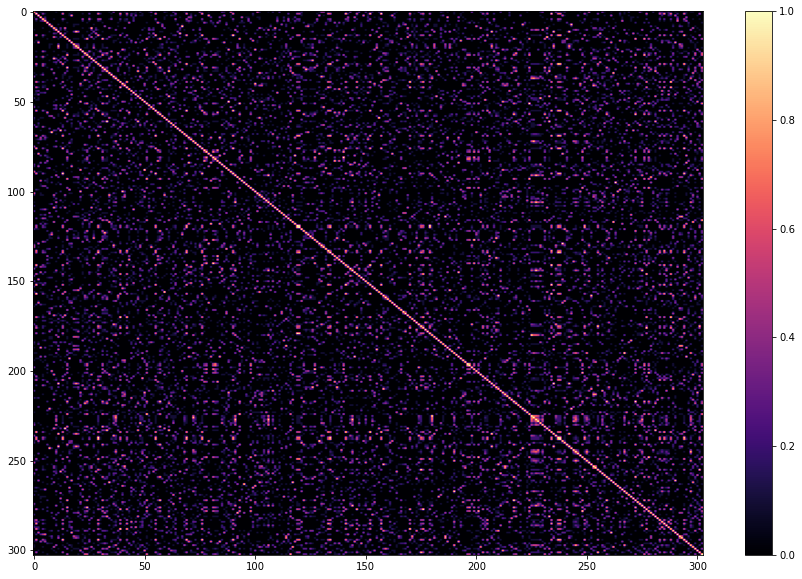

In [19]:
plt.figure(figsize=[15,10])
plt.imshow(proximity_matrix, aspect='auto', cmap='magma')
plt.colorbar()

In [15]:
import time
X_test_proximized = X_test.copy()

change_count = 0
for row in change_list:
    col = row[0]
    index = row[1]
    value = df.loc[index, col]
    
    if col in binary_columns: #TODO: Change to binary values (if in [])
        continue
        count_yes, count_no = 0, 0
        weight_yes, weight_no = 0, 0
        for ix, weight in enumerate(proximity_matrix[index]):
            if df.loc[ix]['target'] == 1:
                count_yes += 1
                weight_yes += weight
            else:
                count_no += 1
                weight_no += weight
        
        total = count_no + count_yes
        total_weights = weight_yes + weight_no
        no = (count_no/total) * (weight_no/total_weights)
        yes = (count_yes/total) * (weight_yes/total_weights)
        
        a = X_test_proximized.loc[index,col]
        X_test_proximized.loc[index, col] = (yes >= no)
        b = X_test_proximized.loc[index,col]
    else: # Numerical collumns
        result = 0
        for ix, weight in enumerate(proximity_matrix[index]):
            result += df_full.loc[ix, col] * (weight / proximity_matrix[index].sum())
        
        a = X_test_proximized.loc[index,col]
        X_test_proximized.loc[index, col] = result
        b = X_test_proximized.loc[index,col]
        
        
    if a != b:
        change_count += 1
        print('changes:',change_count,'==>', test_model(clf, X_train, X_test_proximized, y_train, y_test),"[ diff:",round(a-b,3),"]")
        clear_output(True)

changes: 49 ==> 0.8125 [ diff: -1.242 ]


In [16]:
test_model(clf, X_train, X_test_proximized, y_train, y_test)

0.8125

In [17]:
print(X_train.columns)
X_train.exang.unique()

Index(['sex', 'age', 'chol', 'trestbps', 'exang'], dtype='object')


array([0, 1], dtype=int64)